In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(digest)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
set.seed(7493)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Here we are reading the data. From a URL and changing the values of the AwayTeam and HomeTeam as factors to create distinct teams. Next, the results to be predicted, FTHG and FTAG are also changed to integer values instead of decimals because the number of goals scored in a soccer game is always an integer value. FTHG = full time home goals. FTAG = full time away goals. We also change FTR (full time results) to factors so the data can be split evenly. FTR is also a value to be predicted.

In [2]:
url <- "https://raw.githubusercontent.com/armanmoztar/group-project/main/data/season_2018.csv"

match_data <- read_csv(url) %>%    #reading the csv from url
            mutate(FTR = as_factor(FTR),       # mutate changes the data in the types we want
                  AwayTeam = as_factor(AwayTeam),
                  FTHG = as.integer(FTHG),
                  FTAG = as.integer(FTAG),
                  HomeTeam = as_factor(HomeTeam))



Parsed with column specification:
cols(
  .default = col_double(),
  Div = col_character(),
  Date = col_character(),
  HomeTeam = col_character(),
  AwayTeam = col_character(),
  FTR = col_character(),
  HTR = col_character(),
  Referee = col_character()
)

See spec(...) for full column specifications.



### Table 1

In [22]:
match_data

Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,⋯,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
<chr>,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,⋯,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,⋯,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,⋯,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,⋯,2.29,22,-1.5,2.27,2.16,1.80,1.73,1.37,5.36,8.49
E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,⋯,2.07,19,-0.5,2.13,2.08,1.85,1.80,1.91,3.81,4.15
E0,12/05/2019,Watford,West Ham,1,4,A,0,2,A,⋯,2.44,19,-0.5,2.25,2.19,1.78,1.72,2.11,3.86,3.41


Below we create an initial split of data to seperate the training and testing data. We are using a porportion of 75% training data and 25% testing data. The strata is set to FTR (full time results), to get an even split of games where the home team wins and where the home team loses. 

In [5]:
match_split <- initial_split(match_data, prop = 3/4, strata = "FTR")   #creating the initial split with the parameters described above
match_train <- training(match_split)   #the training data
match_test <- testing(match_split)     #the testing data


This is just a simple visualization to demonstrate what our data represents. Below represents the number of matches won by each home team. We are using the group by and summary functions to see which teams have won the most amount of games and home and the most amount of games away. Note: This visualization is not essential to the regression but demonstrates how the results of our data can be used to create predictions for tables of this sort. Being able to make predictions like this table can guide a person's betting decisions.  

In [6]:
training_summary_netscore <- match_train %>%   
                group_by(FTR, HomeTeam, AwayTeam, FTHG, FTAG) %>%
                summarize() %>% 
                mutate(Net_Score = FTHG - FTAG)  #this subtracts the full time home team goals from the full time away team goals. 
                                                # this value (NetScore) represents which team wins the game and by how much. For example
                                                # if the value is 0, then the game ends in a draw, if the value is positive, then the home team
                                                # scored more goals, meaning that the home team won and if the value is negative, then the away
                                                # team won by the amount given as NetScore. 


`summarise()` regrouping output by 'FTR', 'HomeTeam', 'AwayTeam', 'FTHG' (override with `.groups` argument)



### Table 2

In [7]:
training_summary_netscore

FTR,HomeTeam,AwayTeam,FTHG,FTAG,Net_Score
<fct>,<fct>,<fct>,<int>,<int>,<int>
H,Man United,Brighton,2,1,1
H,Man United,Everton,2,1,1
H,Man United,West Ham,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮
D,Crystal Palace,Everton,0,0,0
D,Crystal Palace,West Ham,1,1,0
D,Crystal Palace,Newcastle,0,0,0


In [8]:
training_summary_nwin_home <- match_train %>% 
                group_by(FTR, HomeTeam) %>%
                summarize(TotalWinsHome = n()) %>% 
                arrange(desc(TotalWinsHome))  #arranging by descending number of wins


`summarise()` regrouping output by 'FTR' (override with `.groups` argument)



### Table 4

In [9]:
training_summary_nwin_home

FTR,HomeTeam,TotalWinsHome
<fct>,<fct>,<int>
H,Liverpool,15
H,Man City,15
H,Arsenal,12
⋮,⋮,⋮
D,Newcastle,1
D,Cardiff,1
D,Everton,1


In [11]:
training_summary_nwin_away <- match_train %>% 
                group_by(FTR, AwayTeam) %>%
                summarize(TotalWinsAway = n()) %>% 
                arrange(desc(TotalWinsAway))  #arranging by descending number of wins


`summarise()` regrouping output by 'FTR' (override with `.groups` argument)



### Table 4

In [12]:
training_summary_netscore

FTR,HomeTeam,AwayTeam,FTHG,FTAG,Net_Score
<fct>,<fct>,<fct>,<int>,<int>,<int>
H,Man United,Brighton,2,1,1
H,Man United,Everton,2,1,1
H,Man United,West Ham,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮
D,Crystal Palace,Everton,0,0,0
D,Crystal Palace,West Ham,1,1,0
D,Crystal Palace,Newcastle,0,0,0


We plan on using a regression model to predict the value of netscore, which will be able to give us our intended results, which are which team wins the game, and by how much.
The below visualization in a form of a scatter plot demonstrates how we will take the value of our prediction (NetScore) and extract the final data we want, which includes which team won and by how much.

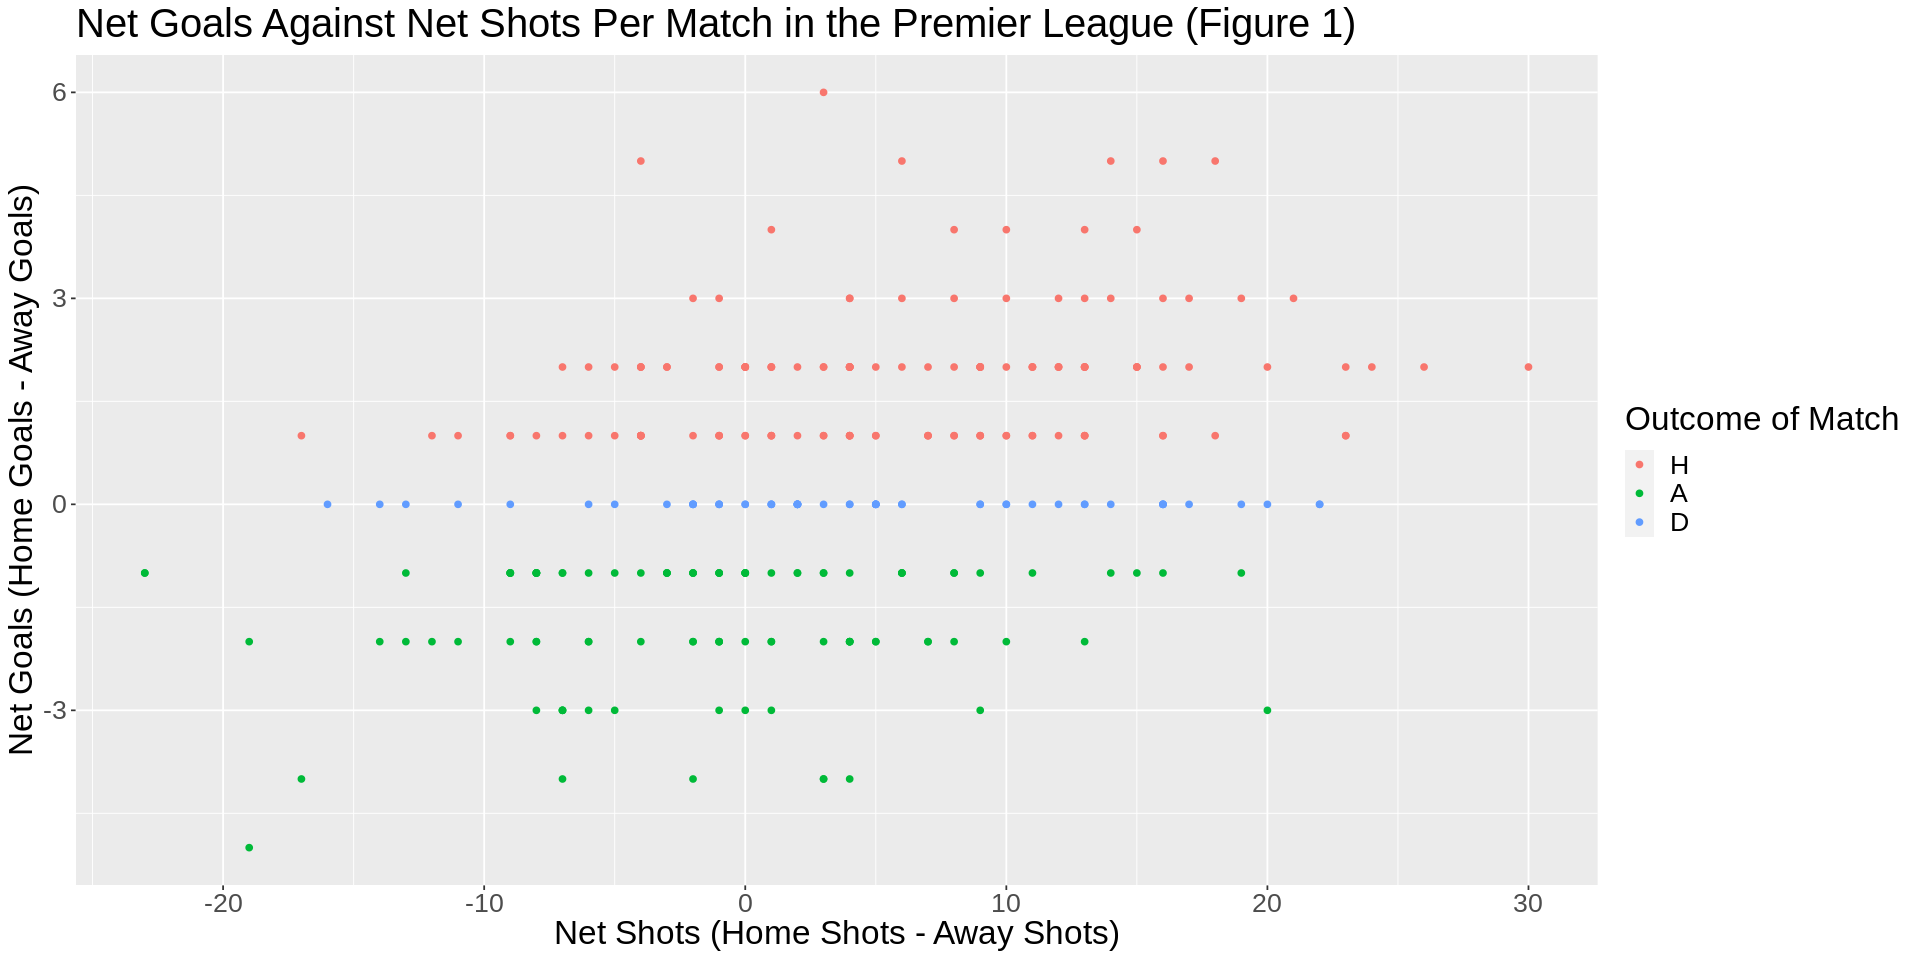

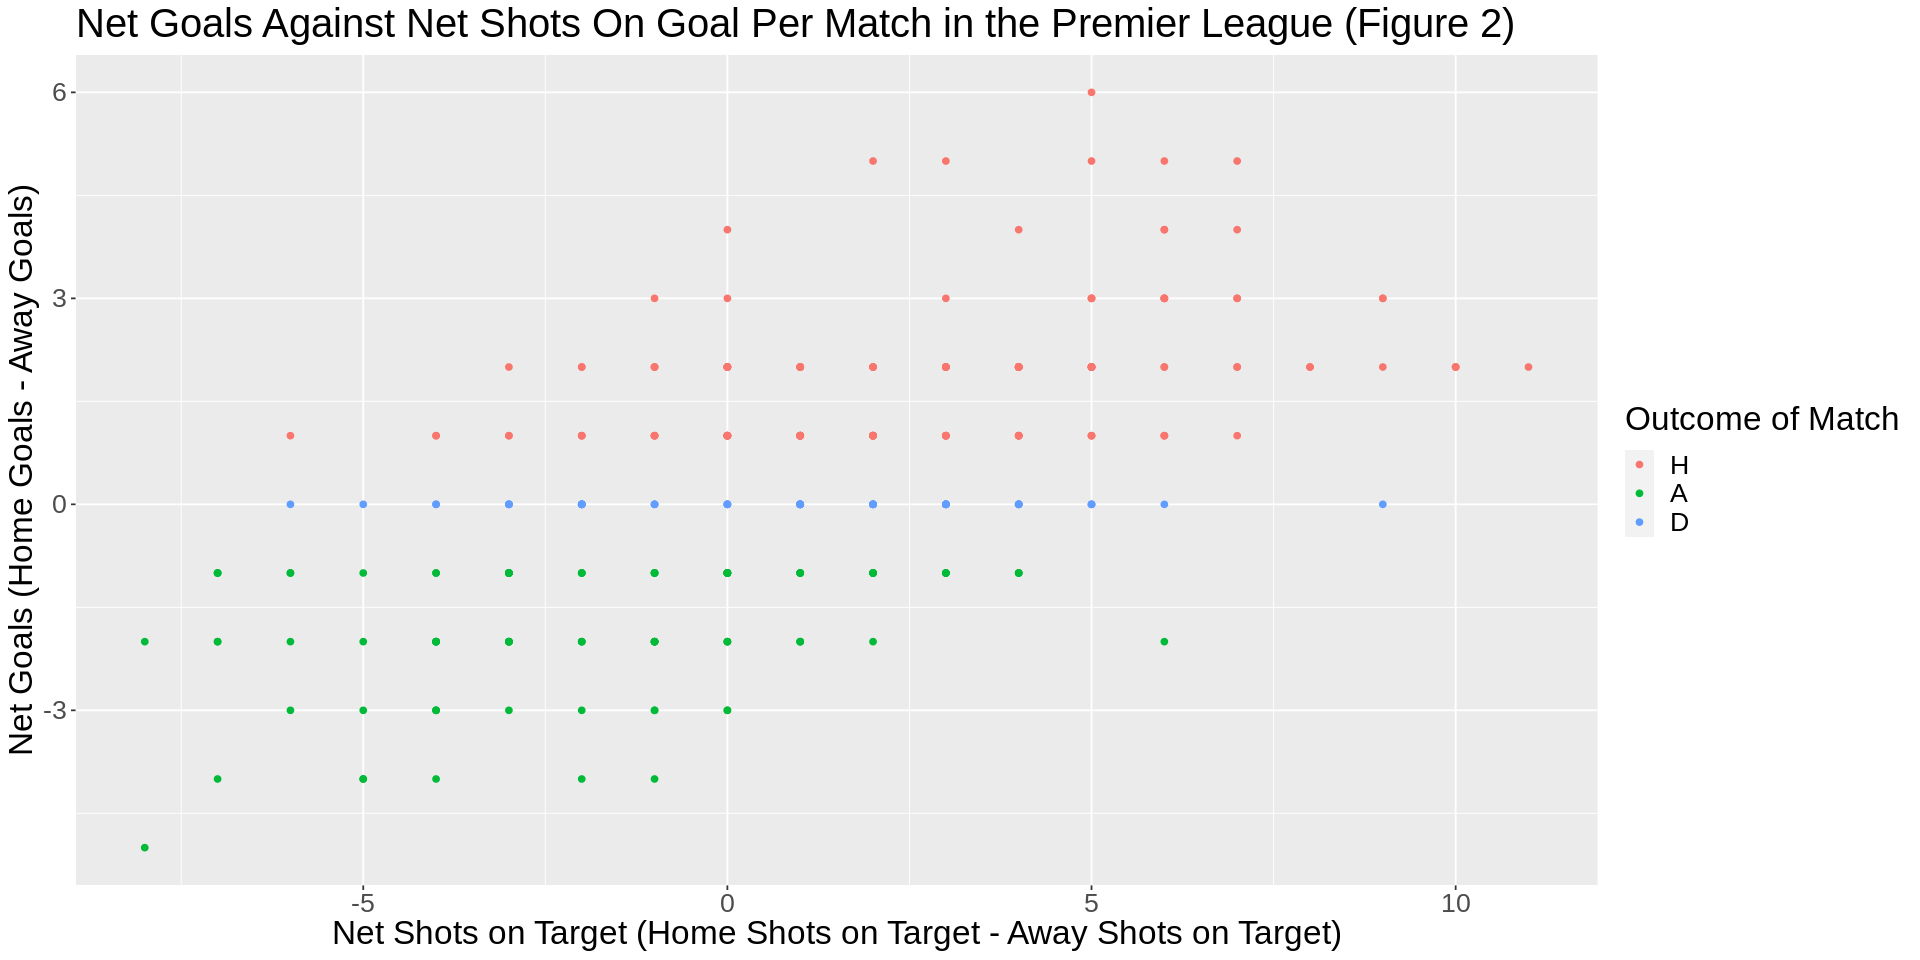

In [14]:
options(repr.plot.height = 8, repr.plot.width = 16)

netscore_vs_netshots_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShots = HS - AS) %>% 
    ggplot(aes(x= NetShots, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots (Home Shots - Away Shots)", y = "Net Goals (Home Goals - Away Goals)", 
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots Per Match in the Premier League (Figure 1)") +
    theme(text = element_text(size=20))

netscore_vs_netshots_ongoal_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShotsOnGoal = HST - AST) %>% 
    ggplot(aes(x= NetShotsOnGoal, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots on Target (Home Shots on Target - Away Shots on Target)", 
         y = "Net Goals (Home Goals - Away Goals)",
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots On Goal Per Match in the Premier League (Figure 2)") +
    theme(text = element_text(size=20))


netscore_vs_netshots_plot
netscore_vs_netshots_ongoal_plot

#### Note that:  H = Home Team Win | D = Draw/Tie | A = Away Team Win

#### Variable explanation:
We plan on using the following factors to conduct our data analysis:
Chosen Variables/Columns| Justification: 

FTHG and HG = Full Time Home Team Goals
Testing Data: Not used in our predictions
FTAG and AG = Full Time Away Team Goals
Testing Data: Not used in our predictions
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
Testing Data: Not used in our predictions
HTHG = Half Time Home Team Goals
Allows for performance assessment at half time when paired with total attempted team shots.
HTAG = Half Time Away Team Goals


HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)


HS = Home Team Shots
Combined with total team goals, total team shots allow us to further predict the accuracy of the team at halftime.
AS = Away Team Shots


HST = Home Team Shots on Target
(Shot blocked by opponent’s goalie)
This factor pair gives us an idea of how many times a team got close to the opponent’s net and the effectiveness of their 
opponent’s goalie.
AST = Away Team Shots on Target
(Shot blocked by opponent’s goalie)


HHW = Home Team Hit Woodwork
Alongside HST and AST, these factors show us how many times a team got within shooting distance of the net.
AHW = Away Team Hit Woodwork


HC = Home Team Corners
Shows a team’s accuracy and how often the team reaches the opponent’s goal.
AC = Away Team Corners


HFKC = Home Team Free Kicks Conceded


AFKC = Away Team Free Kicks Conceded


HO = Home Team Offsides
Frequency of fouls and how often the team is around the opponent’s goal
AO = Away Team Offsides



### Expected outcomes and significance
In our data analysis, we expect to successfully and accurately find the winner between two teams, alongside the final score. 
These findings could increase the probability of an accurate prediction regarding the outcome of a game between two teams. Our 
analysis can then be used to answer future questions, such as : Which team in a league has the greatest chances of winning for 
the given season?


# Creating the Regression Model

Below we will create the regression model to predict NetScore using both KNN and linear regression to compare which method leads to a better result with a lower RMPSE. Minor iterations will also be done testing which predictor variables lead to the best reression results. 

In [16]:
match_train <- mutate(match_train, NetScore = FTHG - FTAG) #Creating the NetScore collumns for training data
match_test <- mutate(match_test, NetScore = FTHG - FTAG) #Creating the NetScore collumns for testing data

##### Creating KNN Regression Model

In [ ]:
set.seed(1234) #setting the seed so the regression predictions are reproducible

# using 5 fold cross validation to get multiple subsplits wihtin the training data to choose the best value for k
match_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("regression") 

# recipe varition 1, that includes less predictors. The predictors in this variable include: home/away team half time goals, home/away shots, 
# home/away shots on target and we also include existing betting data from other users to pickup trends in the betting odds. collumns B365H:IWA 
# all consist of the betting odds from various betting websites
match_recipe_home_1 <- recipe(NetScore ~ HTHG+HTAG+HS+AS+HST+AST+#HF+AF+HC+AC+HY+AY+HR+AR+
                            B365H+B365D+B365A+BWH+BWD+BWA+IWH+IWD+IWA, data = match_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

# recipe variation 2: this one includes all the previous predictors in recipe 1 but add in; home/away fouls, home/away corners
match_recipe_home_2 <- recipe(NetScore ~ HTHG+HTAG+HS+AS+HST+AST+HF+AF+HC+AC+#HY+AY+HR+AR+
                            B365H+B365D+B365A+BWH+BWD+BWA+IWH+IWD+IWA, data = match_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

# recipe variation 3: this one includes all the previous predictors in recipe 1&2 but add in; home/away yellow cards and home/away red cards
match_recipe_home_3 <- recipe(NetScore ~ HTHG+HTAG+HS+AS+HST+AST+HF+AF+HC+AC+#HY+AY+HR+AR+
                            B365H+B365D+B365A+BWH+BWD+BWA+IWH+IWD+IWA, data = match_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

#splitting up the training data into 5 cross validation splits so that random variations have less of an impact on the chosen k value
match_vfold <- vfold_cv(match_train, v=5, strata = NetScore)

#implementing each variation of the recipe into its own workflow so that we can compare which recipe gives the best predictions

#uses recipe 1:
match_workflow_1 <- workflow() %>% 
    add_recipe(match_recipe_home_1) %>% 
    add_model(match_spec)
#uses recipe 2:
match_workflow_2 <- workflow() %>% 
    add_recipe(match_recipe_home_2) %>% 
    add_model(match_spec)
#uses recipe 3:
match_workflow_3 <- workflow() %>% 
    add_recipe(match_recipe_home_3) %>% 
    add_model(match_spec)

#making a tibble of possible k values ranging from 1 to 200
gridvals <- tibble(neighbors = seq(from = 1, to = 200))

# now implemeniting each workflow and collecting metrics in order to compare each recipe
match_results_1 <- match_workflow_1 %>% 
        tune_grid(resamples = match_vfold, grid = gridvals) %>% 
        collect_metrics()
match_results_2 <- match_workflow_2 %>% 
        tune_grid(resamples = match_vfold, grid = gridvals) %>% 
        collect_metrics()
match_results_3 <- match_workflow_3 %>% 
        tune_grid(resamples = match_vfold, grid = gridvals) %>% 
        collect_metrics()

#Here we extract the best possible k value from each recipe variation
match_min_1 <- match_results_1 %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1)


match_min_1



In [ ]:
match_min_2 <- match_results_2 %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1)
match_min_2

In [ ]:
match_min_3 <- match_results_3 %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1)
match_min_3

Here we can observe that recipe 1 performs best with 10 neighbours but recipe's 2 and 3 preform best wtih 19 neighbours each. We can also observe that the mean rmse also differes between each recipe. Recipe 1 has the lowest mean rmse with a value of 1.309 compared to that of 1.326 given from recipe 2 and 3. This means that the combination that can give us the best possible predictions has k=10 and uses the predictors from recipe 1. This could be due to the fact that the extra added predictors don't contribute much of significance and only add random noise that skews the predictions. 

Therefore we will now continue the KNN regression using only match_recipe_home_1 and k=10 neighbours. 

In [8]:
set.seed(1234) #keeping the seed the same so that the results are reproducable

#using the best recipe combination and the best number of neihgbors (k=10)
k_min <- match_min_1 %>%
         pull(neighbors)

match_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

match_best_fit <- workflow() %>%
         add_recipe(match_recipe_home_1) %>%
         add_model(match_best_spec) %>%
         fit(data = match_train)

match_summary <- match_best_fit %>%
          predict(match_test) %>%
          bind_cols(match_test) %>%
          metrics(truth = NetScore, estimate = .pred)

match_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.3944334
rsq,standard,0.5220113
mae,standard,1.1276596


##### Now we have completed the training and testing of our KNN regression model. 

In [1]:
options(repr.plot.width = 7, repr.plot.height = 7) #here we set options for the graph to make a good visualization

#here we bind the collumns of the predictions to the actual values
match_preds_test <- match_best_fit %>% 
        predict(match_test) %>% 
        bind_cols(match_test) %>% 
        mutate(.pred = as.integer(round(.pred))) %>% 
        select(.pred, NetScore) %>%   #select only the real values and the predictions
        mutate(error = NetScore - .pred)

match_preds_train <- match_best_fit %>% 
        predict(match_train) %>% 
        bind_cols(match_train) %>% 
        mutate(.pred = as.integer(round(.pred))) %>% 
        select(.pred, NetScore) %>%   #select only the real values and the predictions
        mutate(error = NetScore - .pred) %>% 
        glimpse()      #we use the glimpse function to just see a visual numerical comparison between our predictions and the actual values

#Because of the high dimensonality of our data, we are unable to make a graph showing our predictions and our results in comparison to our predictors
# therefore instead, we plot a histogram to see our error distrubution, where the error is equal to the difference between the predicted value
# and the actual value.

error_dist_train <- ggplot(match_preds_train, aes(x= error)) + 
   geom_histogram(binwidth = 1) +
   xlab("Error Distribution") +
   ylab("Count of Prediction Comparisons") +
   ggtitle("Training Error Distribution for KNN Regression")

error_dist_test <- ggplot(match_preds_test, aes(x= error)) + 
   geom_histogram(binwidth = 1) +
   xlab("Error Distribution") +
   ylab("Count of Prediction Comparisons") +
   ggtitle("Testing Error Distribution for KNN Regression")

error_dist_test
error_dist_train

ERROR: Error in match_best_fit %>% predict(match_test) %>% bind_cols(match_test) %>% : could not find function "%>%"


Therefore we are finally able to visualize how well our model predicts testing data versus using training data. The x-axis of the histogram represents how close the prediction is to the actual value. Thefore a negative x value means that the predictor was too high (NetScore- .pred) and a positive x value means that the model underpredicted the real value. We can see from the histograms that the error in the training data creates a symmetric bell curve but the testing data creates a bell curve that is asymetrical and skewed to the right. This makes sense as obviously our training data would have less error because thats the data it was trained with. 

From our testing error distribution, we can see that the model tends to underpredict the values of the netscore, but overall it still has a defined peak near x=0.

### Linear Regression Model Creation

In [27]:
set.seed(2020) # DO NOT REMOVE

#creating a linear spec for linear regression
lm_spec <- linear_reg() %>% 
    set_engine("lm") %>% 
    set_mode("regression")

#creating a fitting using the training data and the best recipe identified earlier.
lm_match_fit <- workflow() %>% 
    add_recipe(match_recipe_home_1) %>%  #using the best recipe pinpointed during the knn regression comparison
    add_model(lm_spec) %>% 
    fit(data = match_train) #fitting the model to the training data

#calculating the final rmpse with the testing data and the model
lm_match_rmspe <- lm_match_fit %>% 
    predict(match_test) %>% 
    bind_cols(match_test) %>% 
    metrics(truth = NetScore, estimate = .pred) %>% 
    filter(.metric == "rmse") %>% 
    select(.estimate) %>% 
    pull()
lm_match_rmspe

[1] 1.299872

## Comparing Linear and KNN Regression
When comparing the RMSPE between knn and linear regression, we can observe that (Linear RMPSE = 1.30) and (KNN RMPSE = 1.39). This means that our linear regression model actually predicts the real NetScore better than the knn model!! Therfore our final model should actually be the linear model. This because the linear RMPSE is smaller than the knn RMPSE. 

Lets create the same kind of histogram we created earlier to see how the error distribution is and if that is visually better as well. 

Rows: 286
Columns: 3
$ .pred    <int> -1, -2, -1, 1, -2, 3, 0, 1, 2, 3, 1, 0, 1, 0, 0, 2, 2, 0, 0,…
$ NetScore <int> -2, -3, -1, 2, -2, 4, 0, 1, 2, 2, -1, -2, 2, 0, 0, 1, 2, -1,…
$ error    <int> -1, -1, 0, 1, 0, 1, 0, 0, 0, -1, -2, -2, 1, 0, 0, -1, 0, -1,…


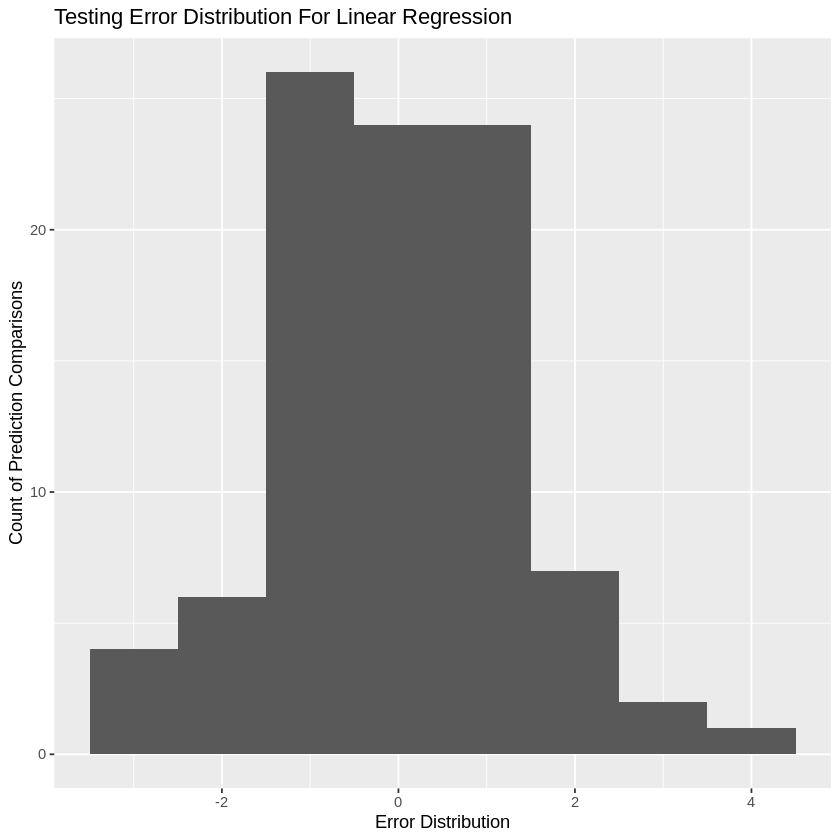

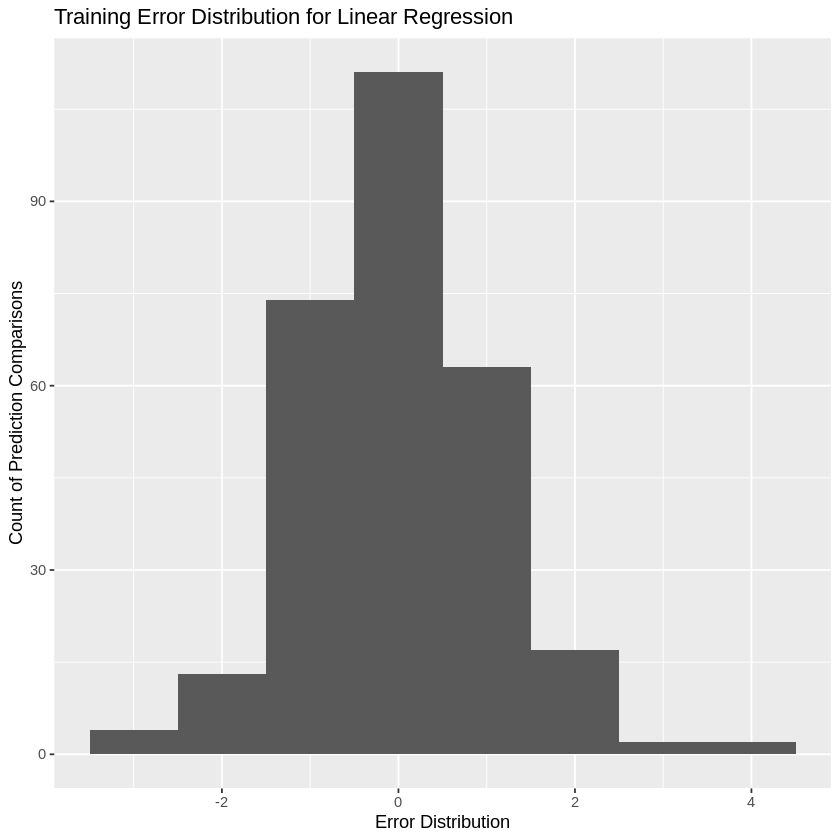

In [29]:
#here we bind the collumns of the predictions to the actual values
match_preds_test_lm <- lm_match_fit %>% 
        predict(match_test) %>% 
        bind_cols(match_test) %>% 
        mutate(.pred = as.integer(round(.pred))) %>% 
        select(.pred, NetScore) %>%   #select only the real values and the predictions
        mutate(error = NetScore - .pred)

match_preds_train_lm <- lm_match_fit %>% 
        predict(match_train) %>% 
        bind_cols(match_train) %>% 
        mutate(.pred = as.integer(round(.pred))) %>% 
        select(.pred, NetScore) %>%   #select only the real values and the predictions
        mutate(error = NetScore - .pred) %>% 
        glimpse()      #we use the glimpse function to just see a visual numerical comparison between our predictions and the actual values

#Because of the high dimensonality of our data, we are unable to make a graph showing our predictions and our results in comparison to our predictors
# therefore instead, we plot a histogram to see our error distrubution, where the error is equal to the difference between the predicted value
# and the actual value.

error_dist_train_lm <- ggplot(match_preds_train_lm, aes(x= error)) + 
   geom_histogram(binwidth = 1) +
   xlab("Error Distribution") +
   ylab("Count of Prediction Comparisons") +
   ggtitle("Training Error Distribution for Linear Regression")

error_dist_test_lm <- ggplot(match_preds_test_lm, aes(x= error)) + 
   geom_histogram(binwidth = 1) +
   xlab("Error Distribution") +
   ylab("Count of Prediction Comparisons") +
   ggtitle("Testing Error Distribution For Linear Regression")

error_dist_test_lm
error_dist_train_lm

### Lets plot the linear and regression error distribution histograms side by side.

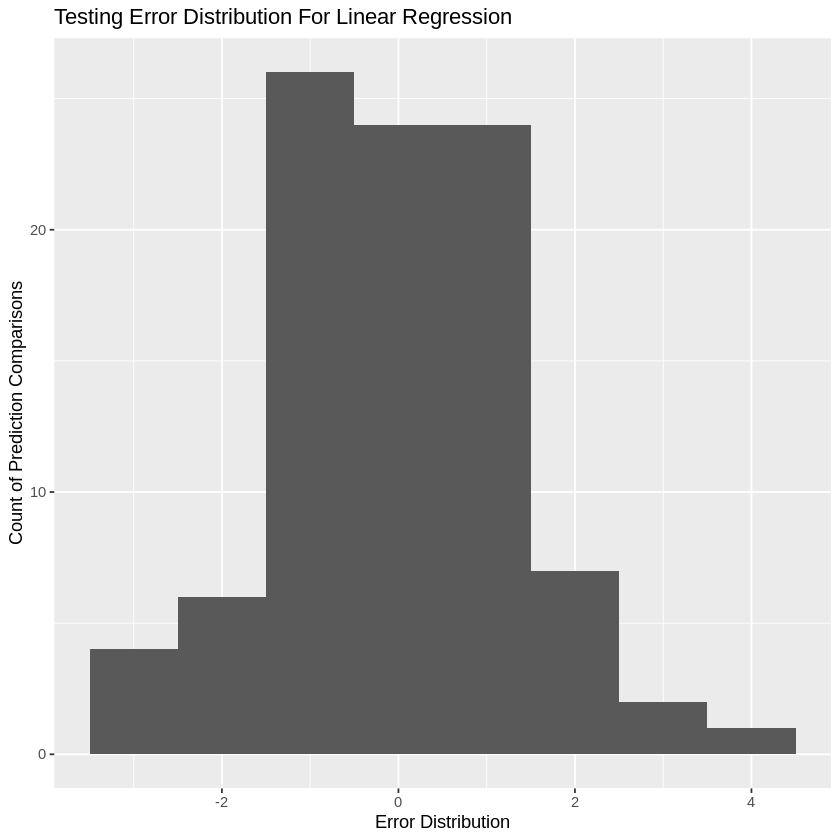

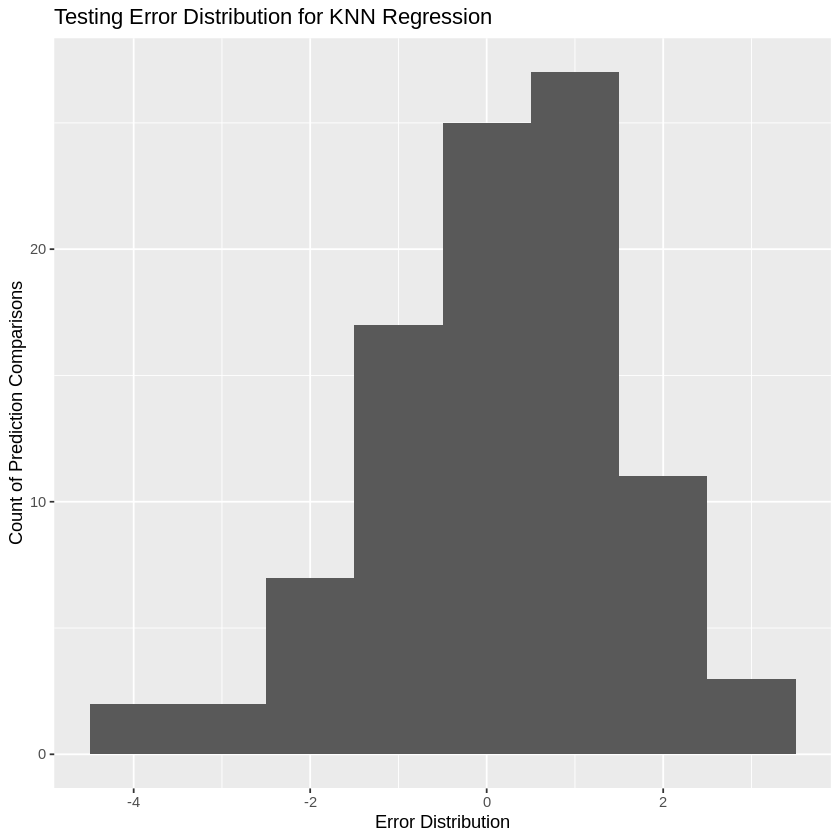

In [33]:
error_dist_test_lm
error_dist_test